In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

## Изучение и подготовка данных

user id - User ID (unique)  
test group - If "ad" the person saw the advertisement, if "psa" they only saw the public service announcement  
converted - If a person bought the product then True, else is False  
total ads - Amount of ads seen by person  
most ads day - Day that the person saw the biggest amount of ads  
most ads hour - Hour of day that the person saw the biggest amount of ads  

The majority of the people will be exposed to ads (the experimental group). And a small portion of people (the control group) would instead see a Public Service Announcement (PSA) (or nothing) in the exact size and place the ad would normally be. 

**Большинство людей увидят рекламу (экспериментальная группа). А небольшая часть людей (контрольная группа) вместо этого увидит публичное объявление (или вообще ничего) в том же размере и в том же месте, в котором обычно размещается реклама.** 

In [2]:
data = pd.read_csv('marketing_AB.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB


In [3]:
data.isna().any()

Unnamed: 0       False
user id          False
test group       False
converted        False
total ads        False
most ads day     False
most ads hour    False
dtype: bool

In [4]:
data.duplicated().any()

np.False_

В данных 7 колонок 588101 строк. Нет пропущенных значений и дубликатов.

In [5]:
data.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


In [6]:
data.drop(columns = ['Unnamed: 0', 'user id'], inplace = True)

In [7]:
data.describe()

,total ads,most ads hour
count,588101.000000,588101.000000
mean,24.820876,14.469061
std,43.715181,4.834634
min,1.000000,0.000000
25%,4.000000,11.000000
50%,13.000000,14.000000
75%,27.000000,18.000000
max,2065.000000,23.000000


In [8]:
#unique values in categorical columns
print("Test Group:", data['test group'].unique())
print("Most Ads Day:", data['most ads day'].unique())
print("Most ads hour:", [int(x) for x in sorted(data['most ads hour'].unique())])
print("Converted:", data['converted'].unique())

Test Group: ['ad' 'psa']
Most Ads Day: ['Monday' 'Tuesday' 'Friday' 'Saturday' 'Wednesday' 'Sunday' 'Thursday']
Most ads hour: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
Converted: [False  True]


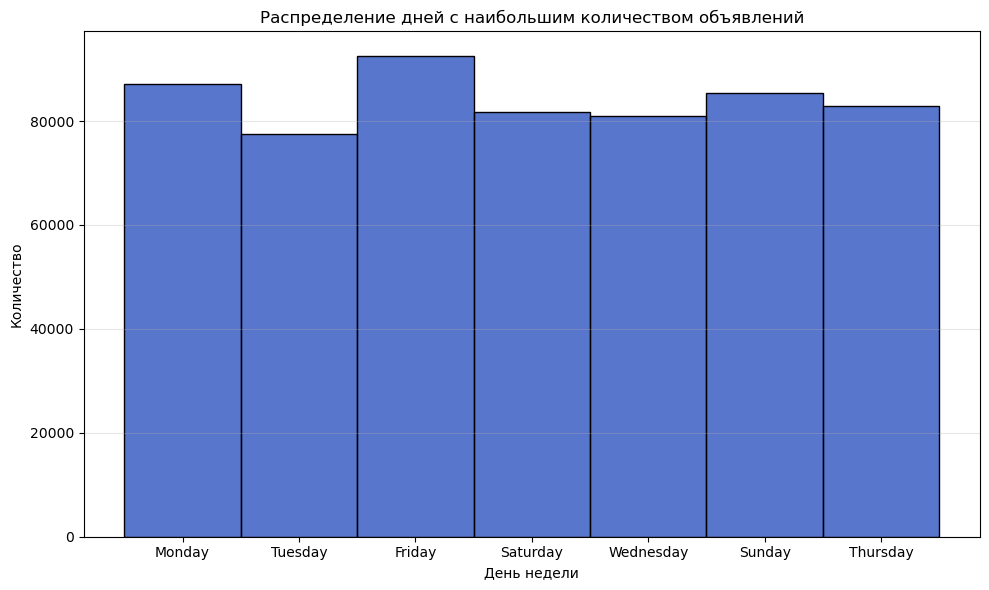

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(
    data['most ads day'],
    color='#2048BA',  # Добавлен символ # для HEX цвета
)

# Добавляем заголовок и подписи осей
plt.title('Распределение дней с наибольшим количеством объявлений')
plt.xlabel('День недели')
plt.ylabel('Количество')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

наблюдения в данных распределены равномерно по дням недели

<Axes: xlabel='most ads hour', ylabel='Count'>

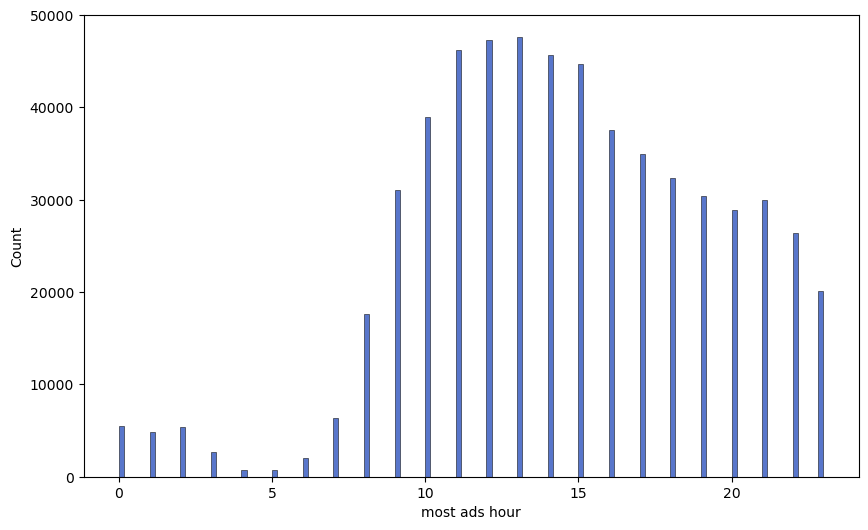

In [10]:
plt.figure(figsize=(10, 6))
sns.histplot(
    data['most ads hour'],
    color='#2048BA',
)

пользователи проявляли активность и видели рекламу\анонс преимущественно с 11 до 14 часов дня.

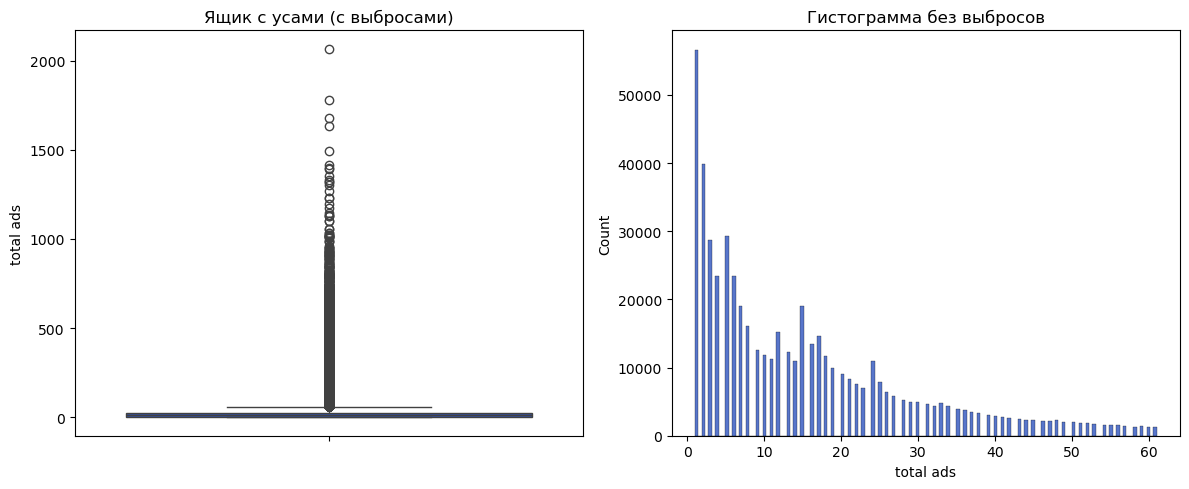

In [11]:
# Убираем выбросы с помощью IQR
Q1 = data['total ads'].quantile(0.25)
Q3 = data['total ads'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

data_no_outliers = data[(data['total ads'] >= lower_bound) & (data['total ads'] <= upper_bound)]

# Строим ящик с усами
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(y=data['total ads'], color='#2048BA')
plt.title('Ящик с усами (с выбросами)')

# Строим гистограмму без выбросов
plt.subplot(1, 2, 2)
sns.histplot(data_no_outliers['total ads'], color='#2048BA')
plt.title('Гистограмма без выбросов')

plt.tight_layout()
plt.show()

В данных обнаружено большое число выбросов. Это обусловлено условиями эксперимента: проверяется влияние большого показа рекламы. Одна, даже если рассматривать основную часть данных, Нормального распределения не наблюдается.

### Обзор ключевых данных

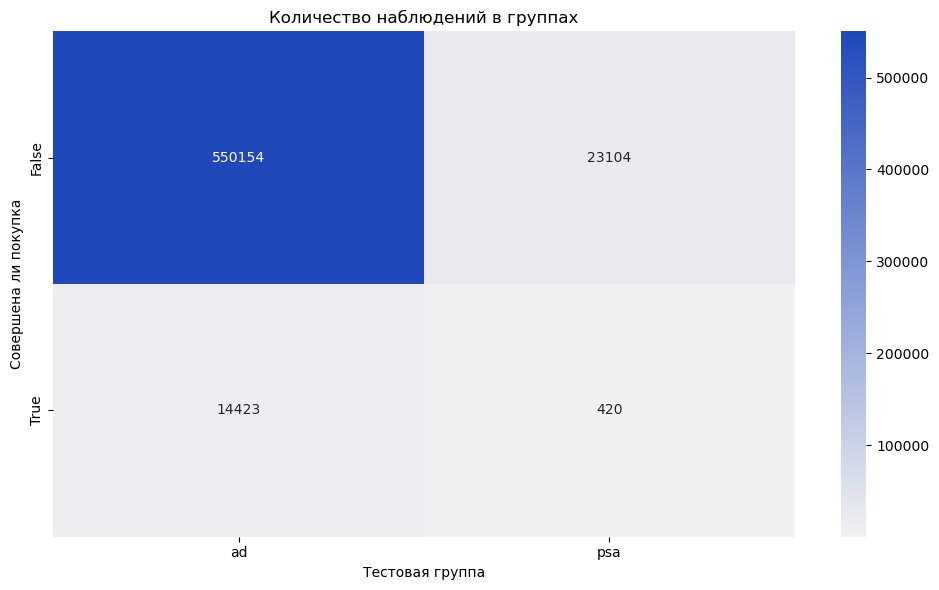

In [12]:
pivot_table = data.groupby(['converted', 'test group']).size().unstack(fill_value=0)

plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot_table, 
    annot=True, 
    fmt='d', 
    cmap=sns.light_palette('#2048BA', as_cmap=True),  # Градиент от светлого к темному
)
plt.title('Количество наблюдений в группах')
plt.xlabel('Тестовая группа')
plt.ylabel('Совершена ли покупка')
plt.tight_layout()
plt.show()

Из тепловой карты мы видим, что большая часть пользователей ничего не покупает и выборка в группе с рекламой больше, чем в группе без. Неравномерное распределение плохо тем, что создает проблему для а\б теста. Статистическая мощность смещена в сторону большей группы.любые эффекты, даже крошечные, становятся значительными.  
Решить эту проблему поможет тестирование через пропорции и Стандартная ошибка. Деление на n в формуле - уменьшение дисперсии при увеличении выборки.

In [13]:
# Простой способ отфильтровать тестовую группу ad
test_group = data[data['test group'] == 'ad'].copy()
control_group = data[data['test group'] == 'psa'].copy()

In [14]:
control_group.describe()

,total ads,most ads hour
count,23524.000000,23524.000000
mean,24.761138,14.304923
std,42.860720,4.656239
min,1.000000,0.000000
25%,4.000000,11.000000
50%,12.000000,14.000000
75%,26.000000,18.000000
max,907.000000,23.000000


In [15]:
test_group.describe()

,total ads,most ads hour
count,564577.000000,564577.000000
mean,24.823365,14.475900
std,43.750456,4.841808
min,1.000000,0.000000
25%,4.000000,11.000000
50%,13.000000,14.000000
75%,27.000000,18.000000
max,2065.000000,23.000000


в контрольной группе максимальное количество пропущенной рекламы - 907, в тестовой, показов рекламы - 2065. Объем контрольной группы - 23534, тестовой - 	564577.

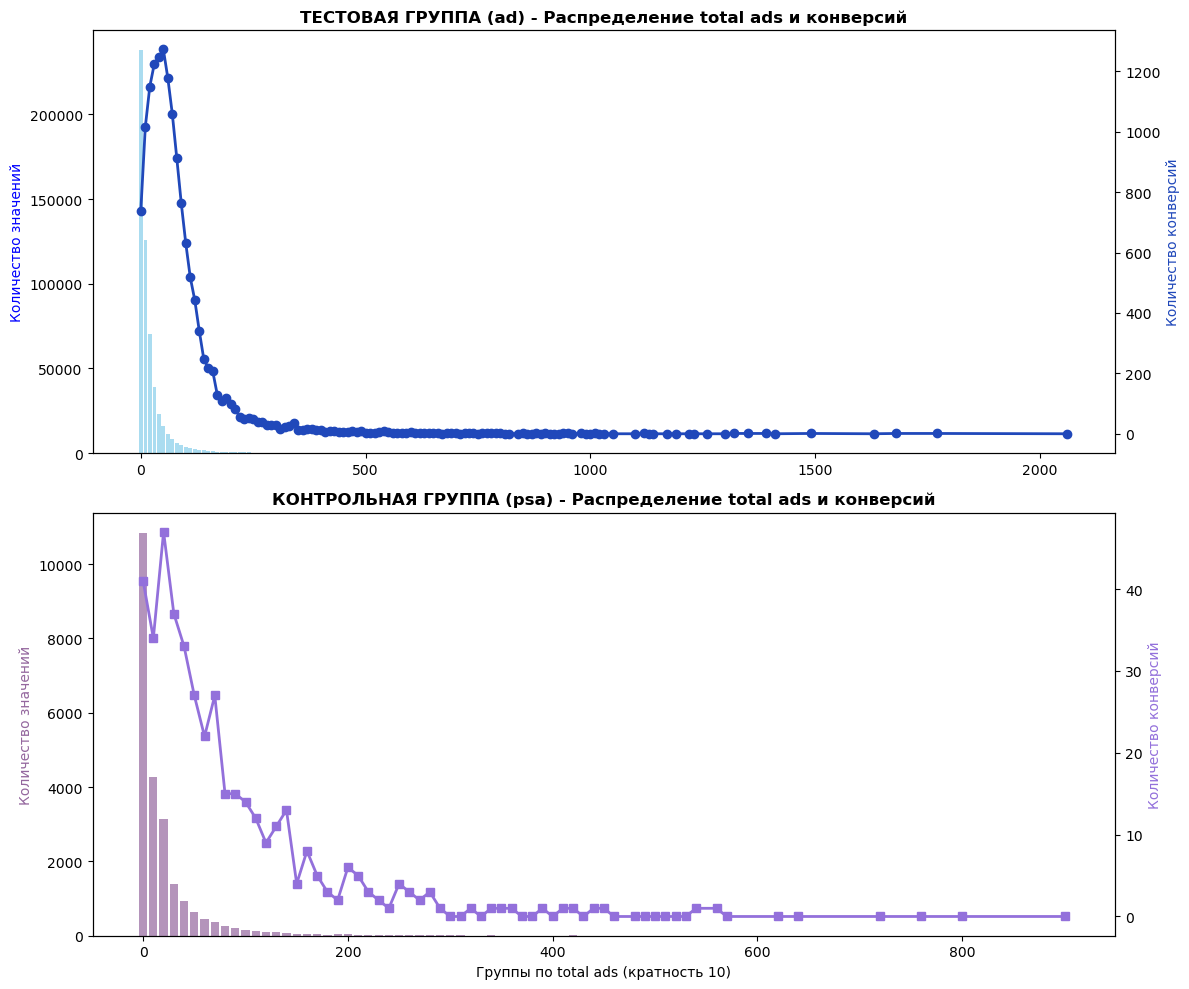

In [16]:

test_group['ads_group'] = (test_group['total ads'] // 10) * 10 
control_group['ads_group'] = (control_group['total ads'] // 10) * 10

# Агрегация для тестовой группы
grouped_test = test_group.groupby('ads_group').agg(
    count=('total ads', 'count'),
    converted_count=('converted', lambda x: x.sum() if x.dtype == bool else (x == True).sum())
).reset_index()

# Агрегация для контрольной группы
grouped_control = control_group.groupby('ads_group').agg(
    count=('total ads', 'count'),
    converted_count=('converted', lambda x: x.sum() if x.dtype == bool else (x == True).sum())
).reset_index()
# ads_group - разбили кол-во показов рекламы на бины по 10
# count - количество значений \строк попавших в бин
# converted_count - количество конверсий в бине

# Создаем два графика друг под другом
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# График для ТЕСТОВОЙ группы (ad)
ax1.bar(grouped_test['ads_group'], grouped_test['count'], alpha=0.7, color='skyblue', width=8, label='Количество пользователей')
ax1.set_ylabel('Количество значений', color='blue')
ax1.set_title('ТЕСТОВАЯ ГРУППА (ad) - Распределение total ads и конверсий', fontweight='bold')

# Второй Y-axis для конверсий (тестовая группа)
ax1_conversion = ax1.twinx()
ax1_conversion.plot(grouped_test['ads_group'], grouped_test['converted_count'], color='#2048BA', marker='o', linewidth=2, label='Конверсии')
ax1_conversion.set_ylabel('Количество конверсий', color='#2048BA')

# График для КОНТРОЛЬНОЙ группы (psa)
ax2.bar(grouped_control['ads_group'], grouped_control['count'], alpha=0.7, color='#94679E', width=8, label='Количество пользователей')
ax2.set_xlabel('Группы по total ads (кратность 10)')
ax2.set_ylabel('Количество значений', color='#94679E')
ax2.set_title('КОНТРОЛЬНАЯ ГРУППА (psa) - Распределение total ads и конверсий', fontweight='bold')

# Второй Y-axis для конверсий (контрольная группа)
ax2_conversion = ax2.twinx()
ax2_conversion.plot(grouped_control['ads_group'], grouped_control['converted_count'], color='#9370DB', marker='s', linewidth=2, label='Конверсии')
ax2_conversion.set_ylabel('Количество конверсий', color='#9370DB')

plt.tight_layout()
plt.show()

Не смотря на разную величину групп, визуально наблюдается общая тенденция: количество конверсий растет до определенного предела, а потом падает, вопреки продолжающемуся росту количества показов рекламы.  
Данные в обеих группах распределены не нормально. Решение - тестирование с применением Центральной предельной теоремы (ЦПТ)

# Выбор подходящего статистического критерия
Чтобы получить статистически значимый результат, важно правильно подобрать статистический тест.  
#### **Определим критерии:**  
очень важно исключить влияние сегментов друг на друга, т.е. пользователь должен быть отнесен строго к одному сегменту. Условиями проведения сбора данных независимость групп гарантирована.  
**Зависимость групп:** группы не зависимы.
**тип данных** - total ads (количество показов рекламы) числовые дискретные, converted (была ли совершена покупка) - категориальные, бинарные  
**Распределение данных:** Даже если отдельные наблюдения - это 0 или 1 в converted, их СРЕДНЕЕ (конверсия) при большом n распределено нормально. Решение - тестирование через ЦПТ.
**Размер групп:** с сильной диспропорцией. Решение - тестирование через пропорции.  

#### **Формулировка Цели:**
**Определение исследовательских вопросов:** Растет ли доля конверсий от показа рекламы?

**Выбор гипотезы:**  
Показ рекламы повышает конверсию в покупку  
H0: показ рекламы НЕ влияет на конверсию  
H1: показ рекламы повышает конверсию   

**Выбор подходящего статистического метода:** на основе типа данных и исследовательских вопросов вы выбираете метод, который наилучшим образом подходит для анализа.

## Обоснование использования proportions_ztest для нашего A/B теста

### 1. Тест на пропорции (доли)
Мы сравниваем долю конверсий в двух независимых группах:  
- Тестовая группа: $n_1$ пользователей, конверсии $k_1$  
- Контрольная группа: $n_2$ пользователей, конверсии $k_2$  

Доля конверсий в каждой группе:  
$$
\hat{p}_1 = \frac{k_1}{n_1}, \quad \hat{p}_2 = \frac{k_2}{n_2}
$$

### 2. Стандартная ошибка (SE)
Стандартная ошибка разницы долей учитывает размеры групп и дисбаланс:  
$$
SE = \sqrt{\frac{p_1(1 - p_1)}{n_1} + \frac{p_2(1 - p_2)}{n_2}}
$$

Каждая группа вносит вклад в дисперсию, меньшая группа даёт больший вклад, дисбаланс учитывается автоматически.

### 3. Расчёт z-статистики
Для проверки гипотезы  
$$
H_0: p_1 - p_2 = 0 \quad \text{против} \quad H_1: p_1 - p_2 > 0
$$
используем z-тест:  
$$
z = \frac{\hat{p}_1 - \hat{p}_2}{SE}
$$

### 4. Центральная предельная теорема (ЦПТ)
Средние конверсии по большим группам будут приближённо нормально распределены:  
$$
\bar{X}_i = \frac{1}{n_i}\sum_{j=1}^{n_i} X_{ij} \sim \mathcal{N}\Big(p_i, \frac{p_i(1-p_i)}{n_i}\Big)
$$
даже если исходные данные бинарные ($X_{ij} = 0,1$), что позволяет использовать z-тест.

### 5. Независимость групп
Группы теста и контроля независимы:  
$$
\text{Cov}(\bar{X}_1, \bar{X}_2) = 0
$$
что является важным условием применения z-теста для двух пропорций.

### 6. Вывод
Все условия выполнения `proportions_ztest` соблюдены:  
- Данные бинарные (конверсии 0/1)  
- Две независимые группы  
- Большие размеры выборок → ЦПТ выполняется  
- Дисбаланс учитывается через SE  

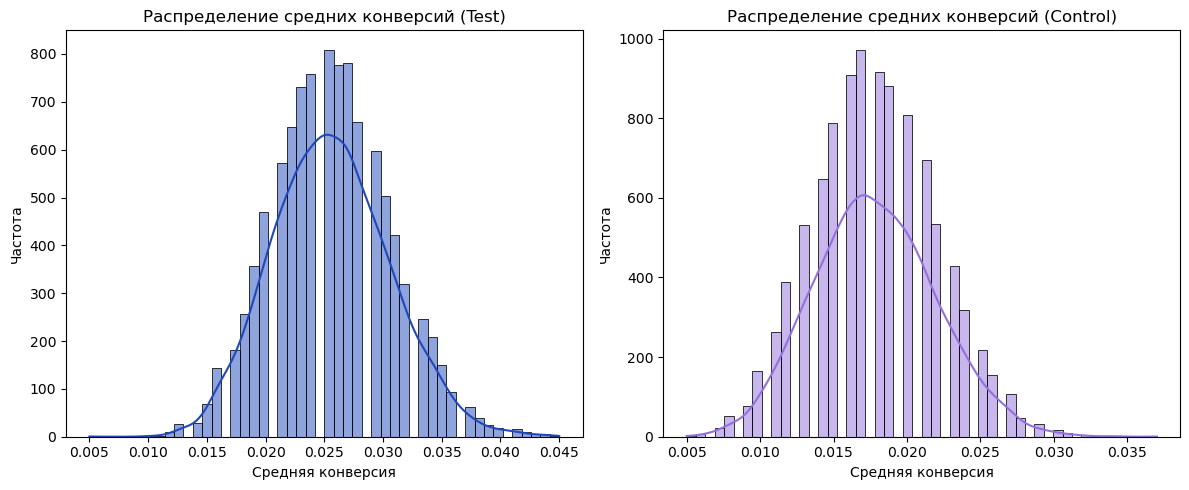

In [17]:
n_samples = 10000      # количество подвыборок
sample_size = 1000     # размер каждой подвыборки

# Функция для генерации средних подвыборок
def sample_means(data, n_samples, sample_size):
    means = []
    for _ in range(n_samples):
        sample = np.random.choice(data, size=sample_size, replace=True)
        means.append(sample.mean())
    return means

# Выборки конверсий
test_conv = data[data['test group']=='ad']['converted'].values
control_conv = data[data['test group']=='psa']['converted'].values

# Средние по подвыборкам
test_means = sample_means(test_conv, n_samples, sample_size)
control_means = sample_means(control_conv, n_samples, sample_size)

# Визуализация распределения средних
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.histplot(test_means, bins=50, kde=True, color='#2048BA')
plt.title('Распределение средних конверсий (Test)')
plt.xlabel('Средняя конверсия')
plt.ylabel('Частота')

plt.subplot(1,2,2)
sns.histplot(control_means, bins=50, kde=True, color='#9370DB')
plt.title('Распределение средних конверсий (Control)')
plt.xlabel('Средняя конверсия')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()


###### *Центральная предельная теорема (ЦПТ) — класс теорем в теории вероятностей, утверждающих, что сумма достаточно большого количества слабо зависимых случайных величин, имеющих примерно одинаковые масштабы (ни одно из слагаемых не доминирует, не вносит в сумму определяющего вклада), имеет распределение, близкое к нормальному. Это происходит независимо от формы исходного распределения каждой из величин. 


Благодаря ЦПТ данные распределены нормально и можно провести ztest.

In [18]:
from statsmodels.stats.proportion import proportions_ztest

# Число конверсий
conversions = data.groupby('test group')['converted'].sum().values
# Размер группы
nobs = data['test group'].value_counts().values

stat, pval = proportions_ztest(count=conversions, nobs=nobs, alternative='larger')  # альтернативная гипотеза: тест > контроль
print(f"z-statistic: {stat}, p-value: {pval}")

z-statistic: 7.3700781265454145, p-value: 8.526403580779863e-14


Статистический тест proportions_ztest показал, что вероятность получить такие результаты случайно (если эффекта нет) = 0.00000000000853%  
Шанс ≈ 1 на 12 триллионов, что это случайность

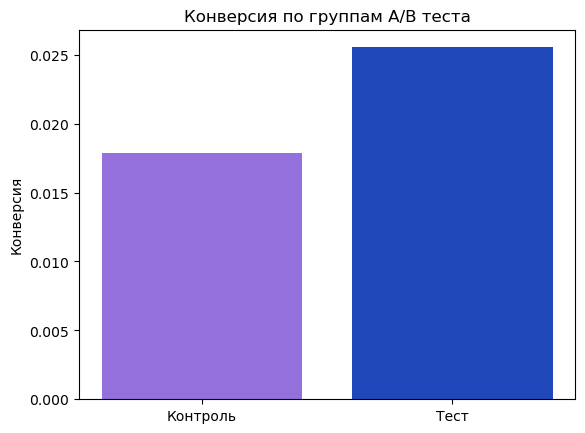

Контроль: 1.79% | Тест: 2.55% | Разница: +0.77%


In [19]:
conv_test = data[data['test group']=='ad']['converted'].mean()
conv_control = data[data['test group']=='psa']['converted'].mean()

plt.bar(['Контроль', 'Тест'], [conv_control, conv_test], color=['#9370DB', '#2048BA'])
plt.ylabel('Конверсия')
plt.title('Конверсия по группам A/B теста')
plt.show()

print(f"Контроль: {conv_control:.2%} | Тест: {conv_test:.2%} | Разница: {conv_test-conv_control:+.2%}")

Разница в стредних значениях котрольной и тестовой группы - 0.77%, что означает, что средний пользователь в тестовой группе" имеет на 0.0077 БОЛЬШЕ вероятность конверсии, чем пользователь в контрольной группе

In [20]:

from statsmodels.stats.proportion import proportion_confint

# # Конверсия по группам
# conv_test = data[data['test group']=='ad']['converted'].mean()
# conv_control = data[data['test group']=='psa']['converted'].mean()

# Количество пользователей в каждой группе
n_test = data[data['test group']=='ad'].shape[0]
n_control = data[data['test group']=='psa'].shape[0]

# Количество конверсий
conv_count_test = data[data['test group']=='ad']['converted'].sum()
conv_count_control = data[data['test group']=='psa']['converted'].sum()

# 95% доверительный интервал для каждой конверсии
ci_test_low, ci_test_high = proportion_confint(conv_count_test, n_test, alpha=0.05, method='normal')
ci_control_low, ci_control_high = proportion_confint(conv_count_control, n_control, alpha=0.05, method='normal')

# Разница и lift
diff = conv_test - conv_control
lift_percent = diff / conv_control * 100

# Доверительный интервал для разницы
diff_ci_low = ci_test_low - ci_control_high
diff_ci_high = ci_test_high - ci_control_low

print(f"Conversion lift: {lift_percent:.2f}%")

Conversion lift: 43.09%


Conversion lift: 43.09% означает, что конверсия в тестовой группе увеличилась на 43.09% по сравнению с контрольной группой.

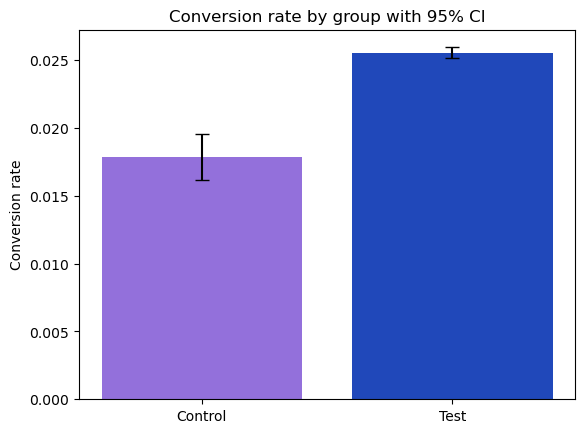

Контроль: 1.79% [1.62%, 1.95%]
Тест: 2.55% [2.51%, 2.60%]
Разница: +0.77%


In [21]:

groups = ['Control', 'Test']
conversions = [conv_control, conv_test]

# Доверительные интервалы для ошибок должны быть в формате: [нижняя_ошибка, верхняя_ошибка]
# Где нижняя_ошибка = conversion - ci_lower, верхняя_ошибка = ci_upper - conversion
ci_lower_errors = [conv_control - ci_control_low, conv_test - ci_test_low]
ci_upper_errors = [ci_control_high - conv_control, ci_test_high - conv_test]

# Объединяем ошибки для yerr
yerr = [ci_lower_errors, ci_upper_errors]

plt.bar(groups, conversions, yerr=yerr, capsize=5, color=['#9370DB', '#2048BA'])
plt.ylabel("Conversion rate")
plt.title("Conversion rate by group with 95% CI")
plt.show()

# Исправленный вывод
print(f"Контроль: {conv_control:.2%} [{ci_control_low:.2%}, {ci_control_high:.2%}]")
print(f"Тест: {conv_test:.2%} [{ci_test_low:.2%}, {ci_test_high:.2%}]")
print(f"Разница: {conv_test - conv_control:+.2%}")

Эти данные означают, что:  
Контроль: 1.79%   - из 100 пользователей 1.79 совершают целевое действие  
Тест:     2.55%   - из 100 пользователей 2.55 совершают целевое действие    
Разница:  +0.77%  - абсолютное увеличение конверсии  
Группа с рекламой дает на 42% больше клиентов из того же трафика, что оказывает значительное положительное влияние на бизнес.

# Рекомендации бизнесу

Рассмотрим снова график распределения конверсий для показов рекламы

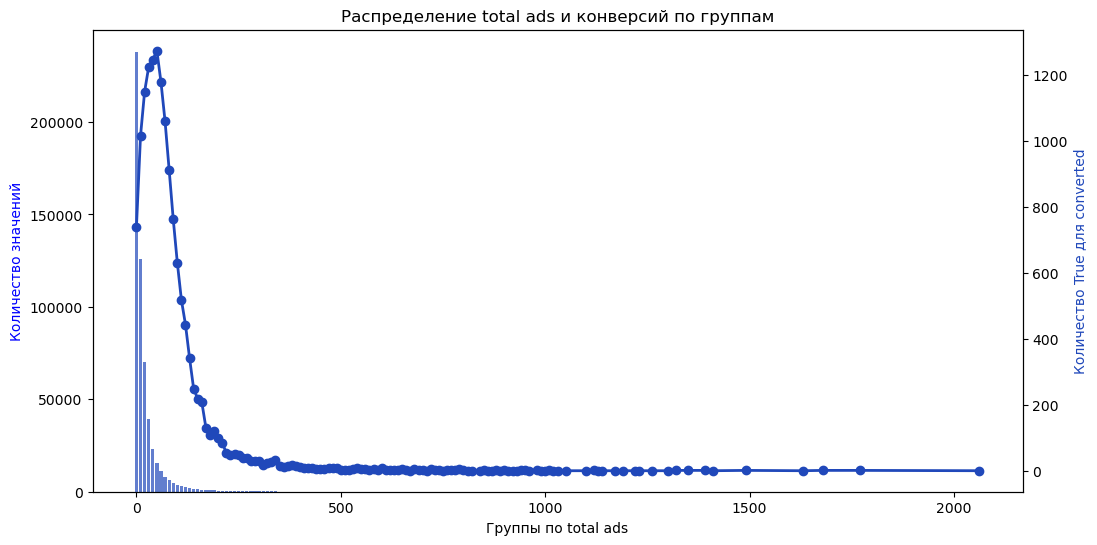

In [22]:
test_group['ads_group'] = (test_group['total ads'] // 10) * 10 

grouped = test_group.groupby('ads_group').agg(
    count=('total ads', 'count'),
    converted_count=('converted', lambda x: x.sum() if x.dtype == bool else (x == True).sum())
).reset_index()

fig, ax1 = plt.subplots(figsize=(12, 6))

# Столбчатая диаграмма
ax1.bar(grouped['ads_group'], grouped['count'], alpha=0.7, color='#2048BA', width=8)
ax1.set_xlabel('Группы по total ads')
ax1.set_ylabel('Количество значений', color='blue')

# Линейный график
ax2 = ax1.twinx()
ax2.plot(grouped['ads_group'], grouped['converted_count'], color='#2048BA', marker='o', linewidth=2)
ax2.set_ylabel('Количество True для converted', color='#2048BA')

plt.title('Распределение total ads и конверсий по группам')
plt.show()


мы видим, что вопреки тому, что количество наблюдений уменьшается с количеством показанной пользователям рекламы, до определенного момента конвертация растет. Это дает нам понять, что крайне маленькие и большие значения в данном тесте не ээфективны. Надо найти оптимальное количество рекламы в тестовой группе.  
Это действие имеет смысл, поскольку слишком малое количество рекламы может попросту ускользнуть от внимания пользователя.с другой стороны, может быть, после 500 показов наступает "рекламная усталость" (banner blindness), и конверсия падает. 

находим оптимальную "дозу" рекламы (например, "не показывать больше 50 роликов одному пользователю") при помощи логистической регрессии:

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

# Подготовка данных для регрессии
X = test_group[['total ads']].values
y = test_group['converted'].values

# Разделяем на обучающую и тестовую выборки (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Создаем полиномиальные признаки и стандартизируем
poly = PolynomialFeatures(degree=2, include_bias=False)
scaler = StandardScaler()

# Применяем преобразования только на обучающей выборке
X_train_poly = poly.fit_transform(X_train)
X_train_scaled = scaler.fit_transform(X_train_poly)
X_train_sm = sm.add_constant(X_train_scaled)

# Применяем те же преобразования к тестовой выборке
X_test_poly = poly.transform(X_test)
X_test_scaled = scaler.transform(X_test_poly)
X_test_sm = sm.add_constant(X_test_scaled)

# Обучаем логистическую регрессию
model = sm.Logit(y_train, X_train_sm).fit()

# Предсказываем на обучающей и тестовой выборках
train_predictions = model.predict(X_train_sm)
test_predictions = model.predict(X_test_sm)

# Вычисляем взвешенный ROC-AUC для обеих выборок
train_auc = roc_auc_score(y_train, train_predictions, average='weighted')
test_auc = roc_auc_score(y_test, test_predictions, average='weighted')


Optimization terminated successfully.
         Current function value: 0.101805
         Iterations 9


🎯 РЕЗУЛЬТАТЫ АНАЛИЗА
Максимум конверсии: 39.416% при 270 показах


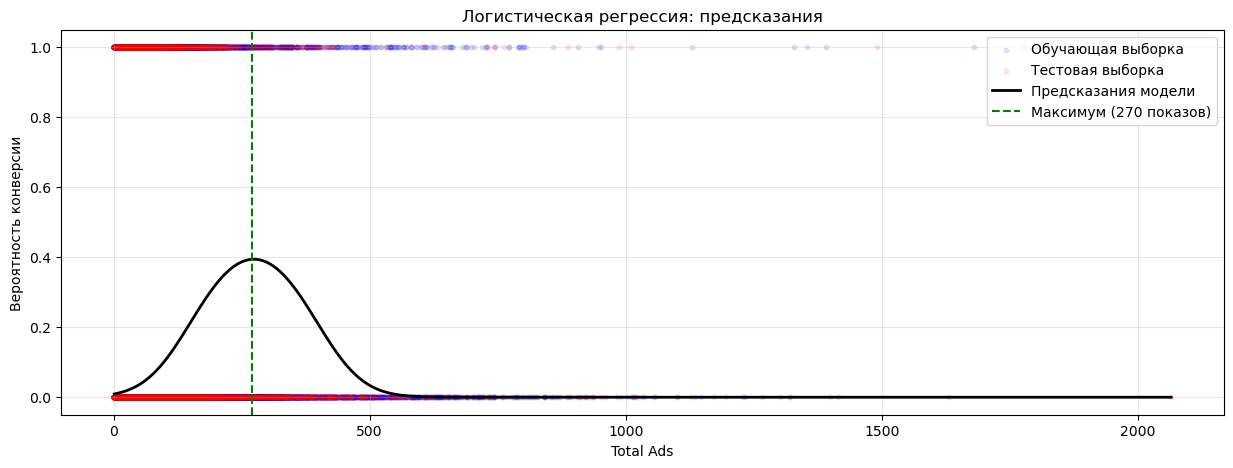

In [24]:
# Предсказываем вероятности конверсии для разных количеств показов
ads_range = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
ads_range_poly = poly.transform(ads_range)
ads_range_scaled = scaler.transform(ads_range_poly)
ads_range_sm = sm.add_constant(ads_range_scaled)
predictions = model.predict(ads_range_sm)

# Находим точку максимума конверсии
max_conv_idx = np.argmax(predictions)
max_conversion_ads = ads_range[max_conv_idx][0]
max_conversion_prob = predictions[max_conv_idx]

print("🎯 РЕЗУЛЬТАТЫ АНАЛИЗА")
print("=" * 60)
print(f"Максимум конверсии: {max_conversion_prob:.3%} при {max_conversion_ads:.0f} показах")

# Визуализация кривых обучения
plt.figure(figsize=(15, 5))

plt.scatter(X_train, y_train, alpha=0.1, color='blue', label='Обучающая выборка', s=10)
plt.scatter(X_test, y_test, alpha=0.1, color='red', label='Тестовая выборка', s=10)
plt.plot(ads_range, predictions, color='black', linewidth=2, label='Предсказания модели')
plt.axvline(x=max_conversion_ads, color='green', linestyle='--', 
            label=f'Максимум ({max_conversion_ads:.0f} показов)')
plt.xlabel('Total Ads')
plt.ylabel('Вероятность конверсии')
plt.title('Логистическая регрессия: предсказания')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)


Максимальная конверсия достигается при 270 показах рекламы пользователю. Проверка переобученности модели:

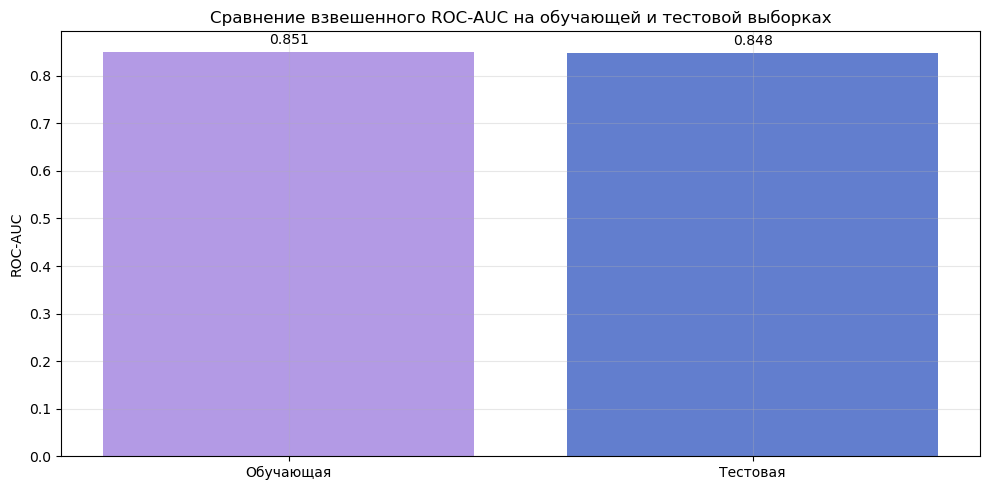

🔍 ДИАГНОСТИКА ПЕРЕОБУЧЕНИЯ
Взвешенный ROC-AUC на обучающей выборке: 0.851
Взвешенный ROC-AUC на тестовой выборке:  0.848
Разница в ROC-AUC: 0.003
✅ Модель обобщается хорошо: маленькая разница в ROC-AUC


In [25]:
from sklearn.metrics import roc_auc_score

# Визуализация
plt.figure(figsize=(10, 5))

# График сравнения ROC-AUC
metrics = ['Обучающая', 'Тестовая']
auc_scores = [train_auc, test_auc]
colors = ['#9370DB', '#2048BA']
bars = plt.bar(metrics, auc_scores, color=colors, alpha=0.7)
plt.ylabel('ROC-AUC')
plt.title('Сравнение взвешенного ROC-AUC на обучающей и тестовой выборках')
for bar, score in zip(bars, auc_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{score:.3f}', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Критерии переобучения
print("🔍 ДИАГНОСТИКА ПЕРЕОБУЧЕНИЯ")
print("=" * 50)
print(f"Взвешенный ROC-AUC на обучающей выборке: {train_auc:.3f}")
print(f"Взвешенный ROC-AUC на тестовой выборке:  {test_auc:.3f}")
print(f"Разница в ROC-AUC: {abs(train_auc - test_auc):.3f}")

if abs(train_auc - test_auc) > 0.05:
    print("⚠️  ВОЗМОЖНОЕ ПЕРЕОБУЧЕНИЕ: большая разница в ROC-AUC (> 0.05)")
else:
    print("✅ Модель обобщается хорошо: маленькая разница в ROC-AUC")

Взвешенный ROC-AUC (AUC_weighted) — это среднее арифметическое значение оценки для каждого класса, взвешенное по числу истинных экземпляров в каждом классе. 
  
Главное преимущество использования ROC-AUC в данном тесте:Устойчивость к изменениям в распределении классов. ROC-AUC остаётся неизменным при изменении соотношения между классами, что делает его удобным для несбалансированных наборов данных.


PR-AUC Train: 0.1303
PR-AUC Test:  0.1304
Разница:      -0.0001


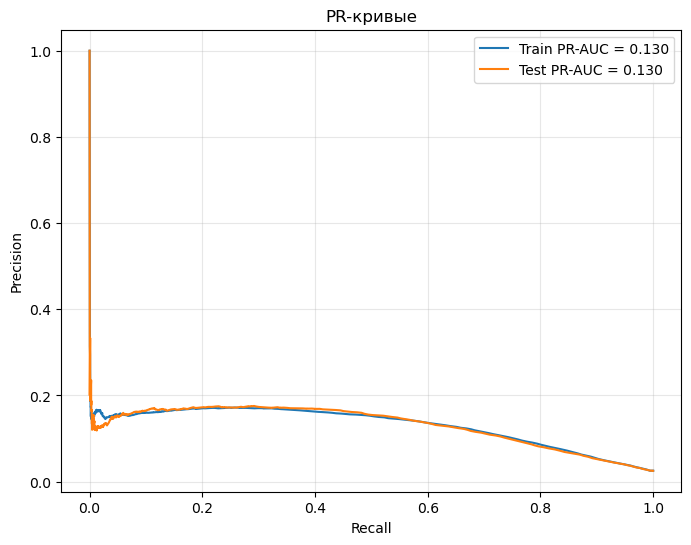

In [26]:
from sklearn.metrics import precision_recall_curve, auc, average_precision_score

# Минимальная версия
precision_train, recall_train, _ = precision_recall_curve(y_train, train_predictions)
precision_test, recall_test, _ = precision_recall_curve(y_test, test_predictions)

pr_auc_train = auc(recall_train, precision_train)
pr_auc_test = auc(recall_test, precision_test)

print(f"PR-AUC Train: {pr_auc_train:.4f}")
print(f"PR-AUC Test:  {pr_auc_test:.4f}")
print(f"Разница:      {pr_auc_train - pr_auc_test:+.4f}")

# Простая визуализация
plt.figure(figsize=(8, 6))
plt.plot(recall_train, precision_train, label=f'Train PR-AUC = {pr_auc_train:.3f}')
plt.plot(recall_test, precision_test, label=f'Test PR-AUC = {pr_auc_test:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR-кривые')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**PR-AUC - хорош в оценке качества на несбалансированных данных**, поскольку фокусируется на качестве предсказания positive класса  
Маленькая разница в значениях train и test - признак отсутствия переобучения

регрессия подтверждает, что после 270 показов конверсия падает, несмотря на рост числа показов. Однако это еще не значит, что 270 показа обеспечивают максимальную финансовую эффективность. Пусть один показ рекламы стоит 0.01 условную единицу, а приносить 10 условных единиц прибыли. посчитаем отимальное количество показов с учетом прибыли:

🎯 Оптимальный лимит показов: 236
💵 Максимальная прибыль: 1.39 у.е. на пользователя


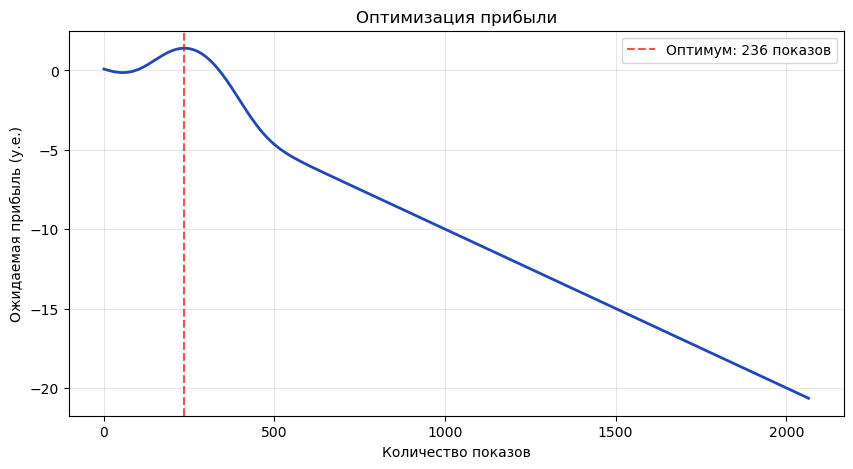

In [27]:
# КОНФИГУРАЦИЯ ЭКОНОМИКИ
REVENUE_PER_CONVERSION = 10  # Доход с одной конверсии
COST_PER_AD = 0.01           # Стоимость одного показа

# Создаем DataFrame для анализа
analysis_df = pd.DataFrame({'ads': ads_range.flatten(), 'conversion_prob': predictions})

# Находим оптимальное количество показов по максимальной прибыли
analysis_df['expected_profit'] = (analysis_df['conversion_prob'] * REVENUE_PER_CONVERSION - 
                                analysis_df['ads'] * COST_PER_AD)
OPTIMAL_ADS = int(analysis_df.loc[analysis_df['expected_profit'].idxmax(), 'ads']) + 1

print(f"🎯 Оптимальный лимит показов: {OPTIMAL_ADS}")
print(f"💵 Максимальная прибыль: {analysis_df['expected_profit'].max():.2f} у.е. на пользователя")

# Визуализация прибыли
plt.figure(figsize=(10, 5))
plt.plot(analysis_df['ads'], analysis_df['expected_profit'], linewidth=2, color='#2048BA')
plt.axvline(x=OPTIMAL_ADS, color='red', linestyle='--', alpha=0.7, label=f'Оптимум: {OPTIMAL_ADS:.0f} показов')
plt.xlabel('Количество показов')
plt.ylabel('Ожидаемая прибыль (у.е.)')
plt.title('Оптимизация прибыли')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Хотя максимальная конверсия наступает при 270 показах рекламы, максимальная прибыль растет до 236 показов. При увеличении показов рекламы конвертация будет расти, но финансовая отдача начнет падать. Сравним финансовые показатели для трех групп - контрольной, тестовой, тестовой до 236 показов и тестовой до 270 показов.

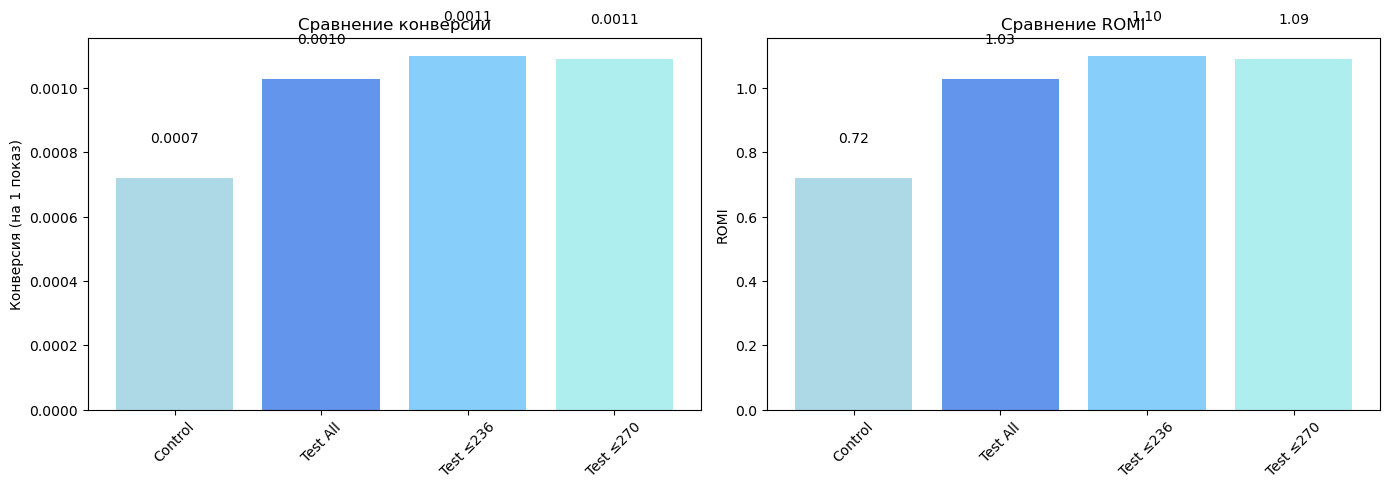

📊 СРАВНЕНИЕ ГРУПП
Конверсия (на 1 показ):
  Control:    0.000721
  Test All:   0.001029 (разница: +0.000308)
  Test ≤236:  0.001100 (разница: +0.000379)
  Test ≤270:  0.001090 (разница: +0.000369)

ROMI:
  Control:    0.72
  Test All:   1.03 (разница: +0.31)
  Test ≤236:  1.10 (разница: +0.38)
  Test ≤270:  1.09 (разница: +0.37)


In [28]:
# Создаем группы для сравнения
control = control_group.copy()
test_all = test_group.copy()
test_236 = test_group[test_group['total ads'] <= 236].copy()
test_270 = test_group[test_group['total ads'] <= 270].copy()

# Рассчитываем среднюю конверсию (учитывая количество показов)
control_conv = control['converted'].sum() / control['total ads'].sum()
test_all_conv = test_all['converted'].sum() / test_all['total ads'].sum()
test_236_conv = test_236['converted'].sum() / test_236['total ads'].sum()
test_270_conv = test_270['converted'].sum() / test_270['total ads'].sum()

# Рассчитываем ROMI для каждой группы
def calculate_romi(group, revenue_per_conversion=10, cost_per_ad=0.01):
    total_revenue = group['converted'].sum() * revenue_per_conversion
    total_cost = group['total ads'].sum() * cost_per_ad
    return total_revenue / total_cost if total_cost > 0 else 0

control_romi = calculate_romi(control)
test_all_romi = calculate_romi(test_all)
test_236_romi = calculate_romi(test_236)
test_270_romi = calculate_romi(test_270)

# Визуализация
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# График конверсии
groups = ['Control', 'Test All', 'Test ≤236', 'Test ≤270']
conversions = [control_conv, test_all_conv, test_236_conv, test_270_conv]
colors = ['lightblue', '#6495ED', '#87CEFA', '#AFEEEE']

bars1 = ax1.bar(groups, conversions, color=colors)
ax1.set_ylabel('Конверсия (на 1 показ)')
ax1.set_title('Сравнение конверсии')
ax1.tick_params(axis='x', rotation=45)

# Добавляем значения на столбцы
for bar, value in zip(bars1, conversions):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.0001,
             f'{value:.4f}', ha='center', va='bottom')

# График ROMI
romi_values = [control_romi, test_all_romi, test_236_romi, test_270_romi]

bars2 = ax2.bar(groups, romi_values, color=colors)
ax2.set_ylabel('ROMI')
ax2.set_title('Сравнение ROMI')
ax2.tick_params(axis='x', rotation=45)

# Добавляем значения на столбцы
for bar, value in zip(bars2, romi_values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{value:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Вывод результатов
print("📊 СРАВНЕНИЕ ГРУПП")
print("=" * 50)
print(f"Конверсия (на 1 показ):")
print(f"  Control:    {control_conv:.6f}")
print(f"  Test All:   {test_all_conv:.6f} (разница: {test_all_conv-control_conv:+.6f})")
print(f"  Test ≤236:  {test_236_conv:.6f} (разница: {test_236_conv-control_conv:+.6f})")
print(f"  Test ≤270:  {test_270_conv:.6f} (разница: {test_270_conv-control_conv:+.6f})")
print()
print(f"ROMI:")
print(f"  Control:    {control_romi:.2f}")
print(f"  Test All:   {test_all_romi:.2f} (разница: {test_all_romi-control_romi:+.2f})")
print(f"  Test ≤236:  {test_236_romi:.2f} (разница: {test_236_romi-control_romi:+.2f})")
print(f"  Test ≤270:  {test_270_romi:.2f} (разница: {test_270_romi-control_romi:+.2f})")

Тестовые группы лучше по конверсии, чем контрольная. При этом полная тестовая группа уступает по средней конверсии урезанным тестовым группам. По показателю ROMI тестовая группа, не показывающая больше 236 реклам, пусть и немного, но превосходит тестовую группу ≤270 показов. 

**ROMI (Return on Marketing Investment)** — это показатель окупаемости затрат на маркетинг. Он позволяет узнать, насколько хорошо сработала реклама и есть ли смысл дальше вкладываться в конкретные каналы продвижения. Если что-то перестаёт работать и деньги «уходят в пустоту», нужно задуматься и скорректировать стратегию.  
**Чем выше ROMI, тем лучше.** Проанализировать метрику можно по такому принципу:  

-- Показатель ниже 0% сигнализирует о том, что вложения не окупаются  
-- Если ROMI выше 0%, значит, продвижение дало плоды  

В результате тестирования стало ясно, что Контрольная группа окупается хуже, в сравнении с тестовыми группами с ограничением.

**По результатам теста, показ рекламы значительно повышает конвертацию - практически в 1,5 раза, в сравнении с группой, которой показывали анонсы или пустые баннеры.**

# Заключение

Тестовая группа значительно увеличивает конвертацию за счет показа рекламы. Бизнесу рекомендуется внедрить рекламу в маркетинговую стратегию. Ожидаемое улучшение от внедрения - повышение конверсии в 1,5 раза и увеличение клиентов из того же трафика на 42%.  
При этом показывать пользователям более 270 реклам не эффективно - после этого значения конверсия начинает падать. С экономической тчоки зрения, пиком экономической производительности является значение в 236 показов реклам. Хотя доля конверсий продолжает расти после этого значения, прибыль с каждой следующей конверсии становится меньше. Бизнесу остается самостоятельно выбирать между прибылью и привлечением покупателей и не рекомендуется показывать пользователям более 270 реклам.